In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta

In [35]:
position_path = "./Data/"
data_path = "./Data/RealRun/"
output_path ="./"



'''Create single CR6 dataframe with datetime for comparisons'''
dict={}
for i in tqdm(range(5462,13774)): #create dataframe of all CR6 data
    try:
        outputsize = len(dict)

        df_CR6 = pd.read_table(data_path+"Younng10Hz"+str(i)+".dat",
                           sep=",",
                          skiprows=[0,2,3])

        for j in range(len(df_CR6)):
            if "." in df_CR6['TIMESTAMP'][j]:
                date = datetime.strptime(df_CR6['TIMESTAMP'][j], '%Y-%m-%d %H:%M:%S.%f')
                #print(date)
            else:
                date = datetime.strptime(df_CR6['TIMESTAMP'][j], '%Y-%m-%d %H:%M:%S')

            #dict[outputsize+j]={"Year":date.year,"Month":date.month,"Day":date.day,"Hour":date.hour,"Minute":date.minute,"Second":date.second+date.microsecond/1000000.,"Record":df_CR6['RECORD'][j],"U (m s^-1)":df_CR6['U'][j],"V (m s^-1)":df_CR6['V'][j],"W (m s^-1)":df_CR6['W'][j],"TSonic (K)":df_CR6['TSonic'][j],"RH (%)":df_CR6['RH'][j],"T_HMP60 (C)":df_CR6['T_HMP60'][j]}
            dict[outputsize+j]={"TIMESTAMP":date,"Record":df_CR6['RECORD'][j],"U (m s^-1)":df_CR6['U'][j],"V (m s^-1)":df_CR6['V'][j],"W (m s^-1)":df_CR6['W'][j],"TSonic (K)":df_CR6['TSonic'][j],"RH (%)":df_CR6['RH'][j],"T_HMP60 (C)":df_CR6['T_HMP60'][j]}    

            #output.loc[outputsize+j,output.columns]=[date.year,date.month,date.day,date.hour,date.minute,date.second+date.microsecond,df_CR6['RECORD'][j],df_CR6['U'][j],df_CR6['V'][j],df_CR6['W'][j],df_CR6['TSonic'][j],df_CR6['RH'][j],df_CR6['T_HMP60'][j]]
            #output = output.append(pd.Series([date.year,date.month,date.day,date.hour,date.minute,date.second+date.microsecond/1000000.,df_CR6['RECORD'][j],df_CR6['U'][j],df_CR6['V'][j],df_CR6['W'][j],df_CR6['TSonic'][j],df_CR6['RH'][j],df_CR6['T_HMP60'][j]], index=output.columns ), ignore_index=True)
    
    except: #if the file is missing just skip it
        pass
        
df_CR6 = pd.DataFrame.from_dict(dict, "index")




100%|██████████████████████████████████████████████████████████████████████████████| 8312/8312 [02:03<00:00, 67.37it/s]


In [37]:
'''START LOOP HERE!!!'''
inputFiles = ['2020-10-03 03-00.xlsx','2020-10-03 03-30.xlsx',
             '2020-10-03 04-00.xlsx','2020-10-03 04-30.xlsx','2020-10-03 05-00.xlsx','2020-10-03 05-30.xlsx','2020-10-03 06-00.xlsx','2020-10-03 06-30.xlsx', '2020-10-03 07-00.xlsx','2020-10-03 07-30.xlsx',
             '2020-10-08 08-00.xlsx','2020-10-08 08-30.xlsx','2020-10-08 09-00.xlsx','2020-10-08 09-30.xlsx','2020-10-08 10-00.xlsx','2020-10-08 10-30.xlsx','2020-10-08 11-00.xlsx','2020-10-08 11-30.xlsx',
             '2020-10-08 12-00.xlsx','2020-10-08 12-30.xlsx','2020-10-08 13-00.xlsx','2020-10-08 13-30.xlsx','2020-10-08 14-00.xlsx','2020-10-08 14-30.xlsx','2020-10-08 15-00.xlsx','2020-10-02 15-30.xlsx']

''''2020-10-02 16-00.xlsx','2020-10-02 16-30.xlsx','2020-10-02 17-00.xlsx','2020-10-02 17-31.xlsx','2020-10-02 18-00.xlsx','2020-10-02 18-30.xlsx','2020-10-02 19-00.xlsx','2020-10-02 19-30.xlsx',
             '2020-10-02 20-00.xlsx','2020-10-02 20-30.xlsx','2020-10-02 21-00.xlsx','2020-10-02 21-30.xlsx','2020-10-02 22-00.xlsx','2020-10-02 22-30.xlsx','2020-10-02 23-00.xlsx','2020-10-02 23-30.xlsx',
             '2020-10-03 00-00.xlsx','2020-10-03 00-30.xlsx','2020-10-03 01-00.xlsx','2020-10-03 01-30.xlsx','2020-10-03 02-00.xlsx','2020-10-03 02-30.xlsx','''


outputFiles = ['03-00','03-30',
              '04-00','04-30','05-00','05-30','06-00','06-30','07-00','07-30',
              '08-00','08-30','09-00','09-30','10-00','10-30','11-00','11-30',
              '12-00','12-30','13-00','13-30','14-00','14-30','15-00','15-30']

''''16-00','16-30','17-00','17-30','18-00','18-30','19-00','19-30',
               '20-00','20-30','21-00','21-30','22-00','22-30','23-00','23-30',
              '00-00','00-30','01-00','01-30','02-00','02-30','''

for j in tqdm(range(len(inputFiles))):
    df_pos = pd.read_excel(position_path+inputFiles[j], header=None)
    df_pos.columns = ['TIMESTAMP', 'X', 'Y', 'THETA']

    '''Create proper timestamps for position'''
    dict ={}
    for i in tqdm(range(len(df_pos))):
        dict[i]={'TIMESTAMP': datetime.fromordinal(int(df_pos['TIMESTAMP'][i])) + timedelta(days=df_pos['TIMESTAMP'][i]%1) - timedelta(days = 366),'X':df_pos['X'][i],'Y':df_pos['Y'][i],'THETA':df_pos['THETA'][i]}
    df_pos = pd.DataFrame.from_dict(dict, "index")



    '''Trim CR6 data based on timestamps from position data. Use new dataframe.'''
    #df_CR6_trim=df_CR6
    
    df_CR6_trim= df_CR6.iloc[df_CR6.index[(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[0].round('100ms'))].tolist()[0]:
                         df_CR6.index[(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[-1].round('100ms'))].tolist()[0]]

    '''for i in tqdm(range((df_CR6_trim['TIMESTAMP']-df_pos['TIMESTAMP'].iloc[-1]).abs().argsort()[:2].iloc[1],len(df_CR6))):
        df_CR6_trim.drop(i, inplace=True)

    for i in tqdm(range(0,(df_CR6_trim['TIMESTAMP']-df_pos['TIMESTAMP'].iloc[0]).abs().argsort()[:2].iloc[0])):
        df_CR6_trim.drop(i, inplace=True)'''

    df_CR6_trim.reset_index(inplace=True, drop=True)


    '''Create a combined database'''
    dict={}
    for i in tqdm(range(len(df_CR6_trim))):
        date = df_CR6_trim["TIMESTAMP"].iloc[i]
        index = (df_pos['TIMESTAMP']-date).abs().argsort()[:2].iloc[1]

        x = df_pos['X'].iloc[index]
        y = df_pos['Y'].iloc[index]
        theta = df_pos['THETA'].iloc[index]

        dict[i]= {"Year":date.year,"Month":date.month,"Day":date.day,"Hour":date.hour,
                  "Minute":date.minute,"Second":date.second+date.microsecond/1000000.,
                  "x":x,"y":y,"theta":theta,
                  "Record":df_CR6_trim['Record'][i],"U (m s^-1)":df_CR6_trim['U (m s^-1)'][i],"V (m s^-1)":df_CR6_trim['V (m s^-1)'][i],
                  "W (m s^-1)":df_CR6_trim['W (m s^-1)'][i],"TSonic (K)":df_CR6_trim['TSonic (K)'][i],"RH (%)":df_CR6_trim['RH (%)'][i],
                  "T_HMP60 (C)":df_CR6_trim['T_HMP60 (C)'][i]}


    df_comb = pd.DataFrame.from_dict(dict, "index")


    '''Create MultiIndex based on each point'''
    point_dict={'p1':[2.8,0.7,0], 'p2':[6.0,0.7,0], 'p3':[6.0,4.4,0], 'p4':[2.8,4.4,0],
               'p5':[6.0,7.9,0], 'p6':[2.8,7.9,0], 'p7':[6.0,10.6,0], 'p8':[4.9,11.8,0]}

    drop=20 #frequency*seconds to drop, make sure the robot is in the correct positon

    dict={'p1':{},'p2':{},'p3':{},'p4':{},'p5':{},'p6':{},'p7':{},'p8':{}}

    for i in tqdm(range(drop, len(df_comb))):
        if ([df_comb['x'].iloc[i-drop],df_comb['y'].iloc[i-drop],df_comb['theta'].iloc[i-drop]] and
           [df_comb['x'].iloc[i],df_comb['y'].iloc[i],df_comb['theta'].iloc[i]]) in point_dict.values(): #Check that it has been there for a while

            point = list(point_dict.keys())[list(point_dict.values()).index([df_comb['x'].iloc[i],df_comb['y'].iloc[i],df_comb['theta'].iloc[i]])] #get the point

            dict[point][i]=df_comb.iloc[i].to_dict()


    dict_of_df = {k: pd.DataFrame(v) for k,v in dict.items()}
    output = pd.concat(dict_of_df, axis=1).transpose()
    output.to_csv('./Data/Binned Data/'+outputFiles[j]+'.csv',index=True)


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14606.46it/s]

  6%|████▋                                                                        | 870/14425 [00:01<00:28, 474.02it/s]


 24%|██████████████████▏                                                         | 3443/14425 [00:08<00:47, 230.15it/s]


 37%|████████████████████████████▏                                               | 5341/14425 [00:15<00:36, 247.60it/s]


 48%|████████████████████████████████████▋                                       | 6952/14425 [00:22<00:30, 248.31it/s]


 60%|█████████████████████████████████████████████▌                              | 8657/14425 [00:29<00:21, 263.85it/s]


 73%|██████████████████████████████████████████████████████▉                    | 10568/14425 [00:36<00:12, 309.39it/s]


 88%|██████████████████████████████████████████████████████████████████         | 12712/14425 [00:43<00:05, 302.04it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14425/14425 [00:48<00:00, 300.20it/s]

 75%|███████████████████████████████████████████████████████▏                  | 10743/14405 [00:01<00:00, 5274.35it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14948.75it/s]

  4%|███▏                                                                         | 601/14397 [00:01<00:26, 520.23it/s]


 24%|█████████████████▉                                                          | 3396/14397 [00:08<00:29, 366.90it/s]


 38%|████████████████████████████▉                                               | 5492/14397 [00:14<00:33, 264.07it/s]


 49%|█████████████████████████████████████▌                                      | 7108/14397 [00:21<00:32, 223.59it/s]


 60%|█████████████████████████████████████████████▉                              | 8701/14397 [00:28<00:26, 218.01it/s]


 73%|██████████████████████████████████████████████████████▍                    | 10444/14397 [00:35<00:15, 252.75it/s]


 85%|███████████████████████████████████████████████████████████████▊           | 12248/14397 [00:43<00:08, 262.80it/s]


100%|██████████████████████████████████████████████████████████████████████████▋| 14338/14397 [00:50<00:00, 280.53it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14397/14397 [00:50<00:00, 286.59it/s]

 71%|███████████████████████████████████████████████████▉                     | 50375/70828 [00:03<00:01, 15108.81it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14687.98it/s]

 16%|████████████▏                                                               | 2305/14423 [00:05<00:33, 360.39it/s]


 31%|███████████████████████▊                                                    | 4522/14423 [00:12<00:34, 289.75it/s]


 43%|████████████████████████████████▉                                           | 6241/14423 [00:19<00:36, 226.30it/s]


 54%|████████████████████████████████████████▉                                   | 7778/14423 [00:26<00:29, 223.13it/s]


 66%|█████████████████████████████████████████████████▉                          | 9473/14423 [00:32<00:18, 267.36it/s]


 79%|██████████████████████████████████████████████████████████▉                | 11344/14423 [00:39<00:10, 289.95it/s]


 94%|██████████████████████████████████████████████████████████████████████▊    | 13611/14423 [00:46<00:02, 370.68it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14423/14423 [00:48<00:00, 296.72it/s]

 36%|██████████████████████████▌                                              | 25805/70828 [00:01<00:03, 12199.93it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14821.46it/s]

 12%|████████▊                                                                   | 1680/14420 [00:03<00:31, 410.00it/s]


 29%|█████████████████████▋                                                      | 4111/14420 [00:10<00:32, 312.50it/s]


 41%|███████████████████████████████▌                                            | 5977/14420 [00:17<00:33, 253.73it/s]


 53%|████████████████████████████████████████                                    | 7592/14420 [00:24<00:28, 239.44it/s]


 64%|████████████████████████████████████████████████▋                           | 9246/14420 [00:31<00:19, 262.82it/s]


 78%|██████████████████████████████████████████████████████████▏                | 11178/14420 [00:38<00:10, 307.33it/s]


 93%|█████████████████████████████████████████████████████████████████████▉     | 13446/14420 [00:44<00:02, 357.11it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14420/14420 [00:47<00:00, 304.12it/s]

 30%|█████████████████████▉                                                   | 21279/70828 [00:01<00:03, 15188.82it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14613.20it/s]

 11%|████████▏                                                                   | 1542/14411 [00:03<00:31, 410.84it/s]


 28%|█████████████████████▏                                                      | 4006/14411 [00:10<00:31, 330.35it/s]


 41%|███████████████████████████████▎                                            | 5938/14411 [00:17<00:32, 260.00it/s]


 53%|████████████████████████████████████████▏                                   | 7617/14411 [00:23<00:27, 243.23it/s]


 65%|█████████████████████████████████████████████████▎                          | 9343/14411 [00:30<00:19, 257.45it/s]


 78%|██████████████████████████████████████████████████████████▎                | 11198/14411 [00:37<00:13, 237.32it/s]


 92%|████████████████████████████████████████████████████████████████████▊      | 13227/14411 [00:44<00:03, 335.91it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14411/14411 [00:47<00:00, 301.68it/s]

 14%|██████████▌                                                              | 10194/70828 [00:00<00:04, 14702.22it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15124.42it/s]

  9%|███████▏                                                                    | 1354/14403 [00:02<00:30, 425.98it/s]


 26%|████████████████████                                                        | 3813/14403 [00:09<00:32, 321.97it/s]


 40%|██████████████████████████████▏                                             | 5712/14403 [00:16<00:34, 248.67it/s]


 51%|██████████████████████████████████████▉                                     | 7371/14403 [00:23<00:30, 232.47it/s]


 63%|███████████████████████████████████████████████▊                            | 9051/14403 [00:30<00:20, 266.81it/s]


 76%|█████████████████████████████████████████████████████████                  | 10954/14403 [00:37<00:12, 275.98it/s]


 91%|████████████████████████████████████████████████████████████████████▍      | 13142/14403 [00:44<00:03, 351.91it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14403/14403 [00:47<00:00, 302.55it/s]

 10%|███████▏                                                                  | 6861/70828 [00:00<00:04, 13379.07it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:05<00:00, 14117.32it/s]

  7%|█████▌                                                                      | 1068/14440 [00:02<00:33, 397.42it/s]


 24%|██████████████████▍                                                         | 3492/14440 [00:09<00:41, 263.57it/s]


 37%|████████████████████████████▍                                               | 5398/14440 [00:16<00:35, 254.98it/s]


 49%|████████████████████████████████████▊                                       | 7004/14440 [00:23<00:35, 210.55it/s]


 60%|█████████████████████████████████████████████▌                              | 8646/14440 [00:29<00:22, 262.25it/s]


 73%|██████████████████████████████████████████████████████▍                    | 10486/14440 [00:36<00:14, 264.53it/s]


 87%|████████████████████████████████████████████████████████████████▉          | 12491/14440 [00:43<00:05, 349.24it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14440/14440 [00:49<00:00, 292.25it/s]

 42%|███████████████████████████████▊                                           | 6118/14420 [00:01<00:01, 5096.96it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:05<00:00, 14128.04it/s]

  0%|▎                                                                             | 50/14405 [00:00<00:29, 489.35it/s]


 19%|██████████████▊                                                             | 2802/14405 [00:07<00:37, 308.16it/s]


 33%|█████████████████████████▏                                                  | 4764/14405 [00:14<00:36, 266.99it/s]


 44%|█████████████████████████████████▍                                          | 6333/14405 [00:21<00:37, 214.67it/s]


 54%|█████████████████████████████████████████▏                                  | 7810/14405 [00:28<00:26, 253.12it/s]


 66%|██████████████████████████████████████████████████▍                         | 9555/14405 [00:35<00:20, 237.60it/s]


 80%|████████████████████████████████████████████████████████████▏              | 11564/14405 [00:42<00:09, 297.63it/s]


 96%|████████████████████████████████████████████████████████████████████████▏  | 13861/14405 [00:49<00:01, 373.41it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14405/14405 [00:50<00:00, 284.96it/s]

 51%|█████████████████████████████████████                                    | 35921/70828 [00:02<00:02, 13507.53it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:05<00:00, 13646.18it/s]

 11%|████████▎                                                                   | 1566/14399 [00:04<00:36, 350.11it/s]


 27%|████████████████████▎                                                       | 3843/14399 [00:11<00:41, 254.07it/s]


 38%|█████████████████████████████                                               | 5498/14399 [00:18<00:40, 219.44it/s]


 48%|████████████████████████████████████▋                                       | 6946/14399 [00:25<00:35, 209.45it/s]


 59%|█████████████████████████████████████████████                               | 8538/14399 [00:32<00:23, 251.03it/s]


 73%|██████████████████████████████████████████████████████▍                    | 10446/14399 [00:39<00:12, 306.52it/s]


 88%|██████████████████████████████████████████████████████████████████         | 12673/14399 [00:45<00:04, 357.78it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14399/14399 [00:50<00:00, 285.89it/s]

 89%|█████████████████████████████████████████████████████████████████▊        | 12792/14379 [00:02<00:00, 5688.05it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14846.85it/s]

  5%|████▏                                                                        | 793/14469 [00:01<00:28, 481.59it/s]


 24%|█████████████████▉                                                          | 3419/14469 [00:08<00:33, 333.88it/s]


 37%|████████████████████████████▎                                               | 5383/14469 [00:15<00:35, 255.95it/s]


 48%|████████████████████████████████████▎                                       | 6915/14469 [00:22<00:39, 190.49it/s]


 59%|████████████████████████████████████████████▍                               | 8468/14469 [00:29<00:23, 258.57it/s]


 72%|█████████████████████████████████████████████████████▋                     | 10351/14469 [00:36<00:15, 273.31it/s]


 86%|████████████████████████████████████████████████████████████████▊          | 12494/14469 [00:43<00:05, 362.67it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14469/14469 [00:48<00:00, 300.29it/s]

 64%|████████████████████████████████████████████████▏                          | 9277/14449 [00:01<00:00, 5528.97it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15365.65it/s]

  3%|██▌                                                                          | 486/14432 [00:00<00:26, 518.10it/s]


 23%|█████████████████▍                                                          | 3306/14432 [00:07<00:31, 352.31it/s]


 37%|████████████████████████████                                                | 5322/14432 [00:14<00:36, 252.31it/s]


 47%|████████████████████████████████████                                        | 6855/14432 [00:21<00:35, 212.14it/s]


 58%|████████████████████████████████████████████▏                               | 8386/14432 [00:28<00:25, 235.44it/s]


 71%|█████████████████████████████████████████████████████▏                     | 10243/14432 [00:35<00:14, 290.22it/s]


 86%|████████████████████████████████████████████████████████████████▌          | 12433/14432 [00:42<00:05, 358.58it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14432/14432 [00:47<00:00, 305.29it/s]

 60%|████████████████████████████████████████████▊                              | 8614/14412 [00:01<00:01, 5489.82it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15357.10it/s]

  3%|██                                                                           | 396/14434 [00:00<00:31, 450.73it/s]


 22%|████████████████▌                                                           | 3138/14434 [00:07<00:36, 309.38it/s]


 35%|██████████████████████████▊                                                 | 5099/14434 [00:14<00:35, 260.96it/s]


 46%|███████████████████████████████████▎                                        | 6700/14434 [00:21<00:34, 221.55it/s]


 57%|███████████████████████████████████████████▋                                | 8293/14434 [00:28<00:24, 247.99it/s]


 70%|████████████████████████████████████████████████████▋                      | 10130/14434 [00:35<00:17, 249.65it/s]


 84%|██████████████████████████████████████████████████████████████▊            | 12086/14434 [00:42<00:07, 317.87it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14434/14434 [00:48<00:00, 297.15it/s]

 25%|██████████████████▋                                                        | 3585/14414 [00:00<00:01, 5861.26it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15619.05it/s]

  0%|▎                                                                             | 57/14433 [00:00<00:25, 569.12it/s]


 21%|████████████████                                                            | 3055/14433 [00:06<00:34, 333.42it/s]


 35%|██████████████████████████▊                                                 | 5090/14433 [00:13<00:37, 246.21it/s]


 47%|███████████████████████████████████▋                                        | 6772/14433 [00:20<00:31, 240.13it/s]


 59%|████████████████████████████████████████████▍                               | 8449/14433 [00:27<00:23, 257.92it/s]


 71%|█████████████████████████████████████████████████████▏                     | 10242/14433 [00:34<00:17, 234.01it/s]


 86%|████████████████████████████████████████████████████████████████▏          | 12354/14433 [00:41<00:06, 315.69it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14433/14433 [00:47<00:00, 306.18it/s]

 43%|████████████████████████████████▌                                          | 6253/14413 [00:01<00:01, 5303.74it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14757.69it/s]

  1%|▋                                                                            | 134/14402 [00:00<00:34, 409.23it/s]


 20%|███████████████                                                             | 2850/14402 [00:07<00:34, 339.40it/s]


 35%|██████████████████████████▋                                                 | 5058/14402 [00:14<00:31, 294.19it/s]


 48%|████████████████████████████████████                                        | 6842/14402 [00:21<00:30, 247.17it/s]


 59%|█████████████████████████████████████████████▏                              | 8552/14402 [00:28<00:21, 268.43it/s]


 72%|██████████████████████████████████████████████████████▏                    | 10410/14402 [00:34<00:14, 280.22it/s]


 87%|█████████████████████████████████████████████████████████████████▎         | 12533/14402 [00:41<00:04, 375.58it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14402/14402 [00:47<00:00, 305.31it/s]

 48%|████████████████████████████████████▎                                      | 6975/14382 [00:01<00:01, 4786.62it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15092.16it/s]

  2%|█▏                                                                           | 225/14430 [00:00<00:32, 439.92it/s]


 20%|███████████████▎                                                            | 2913/14430 [00:07<00:33, 341.72it/s]


 34%|██████████████████████████▏                                                 | 4970/14430 [00:14<00:34, 276.03it/s]


 45%|██████████████████████████████████▌                                         | 6552/14430 [00:21<00:41, 188.59it/s]


 55%|██████████████████████████████████████████▏                                 | 8005/14430 [00:28<00:29, 219.21it/s]


 68%|███████████████████████████████████████████████████▎                        | 9748/14430 [00:35<00:16, 286.64it/s]


 81%|████████████████████████████████████████████████████████████▉              | 11714/14430 [00:42<00:08, 307.58it/s]


 98%|█████████████████████████████████████████████████████████████████████████▋ | 14169/14430 [00:49<00:00, 382.43it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14430/14430 [00:49<00:00, 288.71it/s]

 71%|███████████████████████████████████████████████████▊                     | 50268/70828 [00:03<00:01, 15571.78it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15158.10it/s]

 17%|████████████▊                                                               | 2430/14420 [00:05<00:33, 360.16it/s]


 32%|████████████████████████▎                                                   | 4605/14420 [00:12<00:34, 288.11it/s]


 44%|█████████████████████████████████▎                                          | 6322/14420 [00:19<00:36, 222.76it/s]


 54%|████████████████████████████████████████▉                                   | 7771/14420 [00:26<00:28, 233.92it/s]


 66%|██████████████████████████████████████████████████▎                         | 9557/14420 [00:33<00:16, 299.90it/s]


 80%|████████████████████████████████████████████████████████████▎              | 11598/14420 [00:40<00:09, 309.05it/s]


 97%|████████████████████████████████████████████████████████████████████████▊  | 13990/14420 [00:47<00:01, 412.13it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14420/14420 [00:48<00:00, 299.34it/s]

 60%|███████████████████████████████████████████▋                             | 42435/70828 [00:02<00:01, 14670.57it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14675.06it/s]

 15%|███████████▋                                                                | 2200/14365 [00:04<00:30, 397.35it/s]


 31%|███████████████████████▌                                                    | 4463/14365 [00:11<00:32, 300.54it/s]


 43%|████████████████████████████████▋                                           | 6171/14365 [00:18<00:34, 240.78it/s]


 54%|████████████████████████████████████████▉                                   | 7729/14365 [00:25<00:29, 228.50it/s]


 65%|█████████████████████████████████████████████████▌                          | 9359/14365 [00:32<00:20, 241.97it/s]


 79%|███████████████████████████████████████████████████████████                | 11320/14365 [00:39<00:10, 303.51it/s]


 94%|██████████████████████████████████████████████████████████████████████▋    | 13535/14365 [00:46<00:02, 334.88it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14365/14365 [00:48<00:00, 295.13it/s]

 35%|█████████████████████████▌                                               | 24821/70828 [00:01<00:03, 15250.56it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14870.86it/s]

 11%|████████▏                                                                   | 1538/14350 [00:03<00:35, 362.48it/s]


 27%|████████████████████▌                                                       | 3879/14350 [00:10<00:33, 315.50it/s]


 39%|█████████████████████████████▉                                              | 5651/14350 [00:17<00:40, 214.41it/s]


 49%|█████████████████████████████████████▏                                      | 7026/14350 [00:24<00:41, 176.04it/s]


 59%|████████████████████████████████████████████▋                               | 8433/14350 [00:31<00:26, 223.44it/s]


 70%|████████████████████████████████████████████████████▋                      | 10073/14350 [00:38<00:16, 254.05it/s]


 83%|██████████████████████████████████████████████████████████████▍            | 11955/14350 [00:45<00:07, 302.02it/s]


 99%|██████████████████████████████████████████████████████████████████████████▌| 14265/14350 [00:52<00:00, 397.41it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14350/14350 [00:52<00:00, 273.60it/s]

 74%|██████████████████████████████████████████████████████▎                  | 52686/70828 [00:03<00:01, 15631.11it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14950.99it/s]

 17%|████████████▊                                                               | 2419/14398 [00:05<00:33, 356.52it/s]


 32%|████████████████████████▏                                                   | 4583/14398 [00:12<00:33, 292.86it/s]


 44%|█████████████████████████████████▎                                          | 6311/14398 [00:19<00:35, 226.07it/s]


 55%|█████████████████████████████████████████▌                                  | 7871/14398 [00:26<00:27, 235.19it/s]


 68%|███████████████████████████████████████████████████▌                        | 9772/14398 [00:33<00:16, 285.90it/s]


 83%|██████████████████████████████████████████████████████████████▎            | 11972/14398 [00:39<00:06, 358.11it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14398/14398 [00:45<00:00, 313.90it/s]

 29%|██████████████████████                                                     | 4234/14378 [00:00<00:01, 6008.67it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15902.73it/s]

  1%|▉                                                                            | 183/14339 [00:00<00:23, 600.87it/s]


 22%|████████████████▉                                                           | 3205/14339 [00:07<00:32, 338.44it/s]


 37%|████████████████████████████▏                                               | 5308/14339 [00:14<00:36, 246.66it/s]


 49%|█████████████████████████████████████                                       | 6993/14339 [00:20<00:30, 241.78it/s]


 60%|█████████████████████████████████████████████▉                              | 8674/14339 [00:27<00:21, 267.64it/s]


 74%|███████████████████████████████████████████████████████▌                   | 10621/14339 [00:34<00:11, 316.27it/s]


 90%|███████████████████████████████████████████████████████████████████▌       | 12927/14339 [00:41<00:03, 367.26it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14339/14339 [00:44<00:00, 320.52it/s]

 16%|███████████▍                                                             | 11068/70828 [00:00<00:03, 15834.50it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15843.26it/s]

 10%|███████▌                                                                    | 1421/14358 [00:02<00:27, 472.65it/s]


 28%|█████████████████████▏                                                      | 4009/14358 [00:09<00:30, 338.58it/s]


 42%|███████████████████████████████▌                                            | 5962/14358 [00:16<00:34, 246.46it/s]


 53%|███████████████████████████████████████▉                                    | 7543/14358 [00:23<00:27, 246.15it/s]


 65%|█████████████████████████████████████████████████▍                          | 9350/14358 [00:30<00:17, 280.85it/s]


 79%|███████████████████████████████████████████████████████████▌               | 11413/14358 [00:37<00:09, 315.59it/s]


 97%|████████████████████████████████████████████████████████████████████████▉  | 13975/14358 [00:43<00:00, 436.86it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14358/14358 [00:44<00:00, 320.96it/s]

 70%|███████████████████████████████████████████████████                      | 49528/70828 [00:03<00:01, 16023.33it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15609.15it/s]

 18%|█████████████▊                                                              | 2621/14412 [00:05<00:29, 399.46it/s]


 34%|██████████████████████████                                                  | 4953/14412 [00:12<00:32, 293.92it/s]


 46%|███████████████████████████████████▎                                        | 6698/14412 [00:19<00:34, 225.90it/s]


 58%|███████████████████████████████████████████▋                                | 8293/14412 [00:25<00:24, 247.57it/s]


 71%|█████████████████████████████████████████████████████                      | 10195/14412 [00:32<00:14, 297.63it/s]


 86%|████████████████████████████████████████████████████████████████▊          | 12460/14412 [00:39<00:05, 390.33it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14412/14412 [00:44<00:00, 325.59it/s]

 84%|█████████████████████████████████████████████████████████████▉            | 12056/14392 [00:02<00:00, 5771.29it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15886.97it/s]

  6%|████▊                                                                        | 892/14430 [00:01<00:25, 527.68it/s]


 25%|███████████████████▎                                                        | 3657/14430 [00:08<00:33, 322.44it/s]


 40%|██████████████████████████████▏                                             | 5732/14430 [00:15<00:33, 261.49it/s]


 51%|██████████████████████████████████████▊                                     | 7359/14430 [00:22<00:31, 226.80it/s]


 64%|████████████████████████████████████████████████▎                           | 9167/14430 [00:29<00:18, 287.68it/s]


 78%|██████████████████████████████████████████████████████████▎                | 11214/14430 [00:35<00:09, 330.61it/s]


 95%|███████████████████████████████████████████████████████████████████████▏   | 13692/14430 [00:42<00:01, 407.87it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14430/14430 [00:44<00:00, 325.02it/s]

 52%|██████████████████████████████████████▎                                  | 37175/70828 [00:02<00:02, 16148.64it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16059.07it/s]

 16%|████████████                                                                | 2291/14448 [00:04<00:29, 417.88it/s]


 32%|████████████████████████▌                                                   | 4674/14448 [00:11<00:31, 306.70it/s]


 45%|██████████████████████████████████▏                                         | 6501/14448 [00:18<00:33, 234.92it/s]


 56%|██████████████████████████████████████████▊                                 | 8127/14448 [00:25<00:24, 256.14it/s]


 70%|████████████████████████████████████████████████████▏                      | 10056/14448 [00:31<00:14, 298.82it/s]


 85%|███████████████████████████████████████████████████████████████▋           | 12259/14448 [00:38<00:05, 372.01it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14448/14448 [00:44<00:00, 327.40it/s]

 53%|███████████████████████████████████████▉                                   | 7674/14428 [00:01<00:01, 5956.37it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15258.14it/s]

  3%|██▏                                                                          | 399/14384 [00:00<00:25, 556.48it/s]


 24%|██████████████████▎                                                         | 3476/14384 [00:07<00:28, 379.98it/s]


 39%|█████████████████████████████▋                                              | 5629/14384 [00:14<00:31, 282.07it/s]


 51%|██████████████████████████████████████▉                                     | 7378/14384 [00:21<00:30, 233.14it/s]


 63%|████████████████████████████████████████████████▏                           | 9122/14384 [00:28<00:19, 270.37it/s]


 78%|██████████████████████████████████████████████████████████▏                | 11161/14384 [00:34<00:10, 310.67it/s]


 95%|██████████████████████████████████████████████████████████████████████▉    | 13613/14384 [00:41<00:01, 427.02it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14384/14384 [00:43<00:00, 331.60it/s]

 50%|████████████████████████████████████▌                                    | 36985/73870 [00:02<00:02, 15983.14it/s]


100%|█████████████████████████████████████████████████████████████████████████| 73870/73870 [00:04<00:00, 15617.06it/s]

 14%|██████████▋                                                                 | 2109/14956 [00:04<00:32, 394.84it/s]


 30%|███████████████████████▏                                                    | 4551/14956 [00:11<00:32, 315.63it/s]


 43%|████████████████████████████████▋                                           | 6432/14956 [00:18<00:32, 259.30it/s]


 54%|█████████████████████████████████████████▏                                  | 8103/14956 [00:25<00:27, 246.23it/s]


 66%|██████████████████████████████████████████████████▎                         | 9904/14956 [00:31<00:17, 287.42it/s]


 80%|████████████████████████████████████████████████████████████               | 11965/14956 [00:38<00:09, 317.26it/s]


 97%|████████████████████████████████████████████████████████████████████████▌  | 14472/14956 [00:45<00:01, 421.01it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14956/14956 [00:46<00:00, 321.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [25:44<00:00, 59.40s/it]


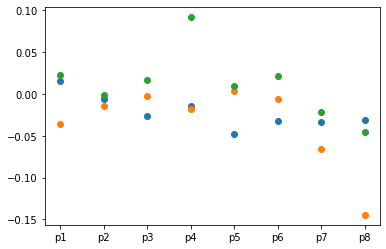

In [38]:
keys=['p1','p2','p3','p4','p5','p6','p7','p8']

plt.scatter(keys,[np.average(output['U (m s^-1)'].loc[i]) for i in keys])
plt.scatter(keys,[np.average(output['V (m s^-1)'].loc[i]) for i in keys])
plt.scatter(keys,[np.average(output['W (m s^-1)'].loc[i]) for i in keys])

plt.show()



In [39]:
type(output)

pandas.core.frame.DataFrame

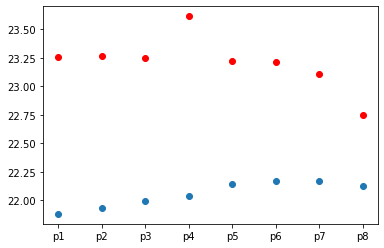

In [40]:
keys=['p1','p2','p3','p4','p5','p6','p7','p8']

plt.scatter(keys,[np.average(output['TSonic (K)'].loc[i])-273 for i in keys], color='red')
plt.scatter(keys,[np.average(output['T_HMP60 (C)'].loc[i]) for i in keys])

plt.show()

In [22]:
ysd=df_CR6.index[(df_CR6['TIMESTAMP'] == df_CR6['TIMESTAMP'].iloc[-1])].tolist()[0]
print(ysd)
print(df_CR6.index[(df_CR6['TIMESTAMP'] == df_CR6['TIMESTAMP'].iloc[8000])])

966846
Int64Index([8000], dtype='int64')


In [24]:
newdf = df_CR6.iloc[df_CR6.index[(df_CR6['TIMESTAMP'] == df_CR6['TIMESTAMP'].iloc[8000])].tolist():df_CR6.index[(df_CR6['TIMESTAMP'] == df_CR6['TIMESTAMP'].iloc[8010])].tolist()[0]]
#newdf = df_CR6.iloc[8000:8010]
print(newdf)

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [[8000]] of <class 'list'>

In [ ]:
tempdf = pd.DataFrame.from_dict({(i,j): dict[i][j] 
                            for i in dict.keys() 
                            for j in dict[i].keys()},
                            orient='index')

tempdf.index = pd.MultiIndex.from_tuples(tempdf.index)

In [ ]:
type(tempdf)

In [ ]:
output.to_csv(index=False)

In [ ]:
arrays = [[1, 1, 2, 2], ['red', 'blue', 'red', 'blue']]
pd.MultiIndex.from_arrays(arrays, names=('number', 'color'))

In [50]:
df_CR6_trim= df_CR6.iloc[df_CR6.index[(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[0].round('100ms'))].tolist()[0]:
                         df_CR6.index[(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[-1].round('100ms'))].tolist()[0]]


In [49]:
(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[0].round('100ms'))

0         False
1         False
2         False
3         False
4         False
          ...  
966842    False
966843    False
966844    False
966845    False
966846    False
Name: TIMESTAMP, Length: 966847, dtype: bool